# **Classification**

## Objectives

* Fit and evaluate a classification model to predict if a mushroom is edible or not.

## Inputs

* outputs/datasets/collection/mushrooms.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modelling pipeline
* Feature importance plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety'

---

# Load Data

In [5]:
import numpy as np
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/mushrooms.csv").drop(['Unnamed: 0'], axis=1)

print(df.shape)
df.head()

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,1,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,1,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,0,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,1,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


---

# ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from category_encoders import TargetEncoder

def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("TargetCategoricalEncoder", TargetEncoder()),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance"))
    ])

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('TargetCategoricalEncoder', TargetEncoder()),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [7]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for Hyperparameter Optimisation

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split Train and Test Set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['class'], axis=1),
    df['class'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6499, 22) (6499,) (1625, 22) (1625,)


## Handle Target Imbalance

In [12]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train, y_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6499, 17) (6499,) (1625, 17) (1625,)


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/feature_engine/select

Check Train Set Target distribution

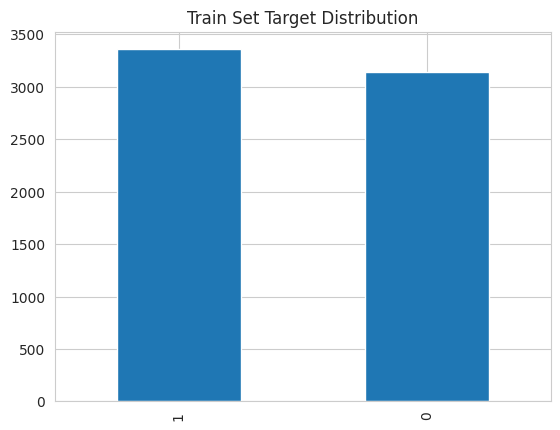

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [17]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6712, 17) (6712,) (1625, 17) (1625,)


Check Train Set Target distribution after resampling

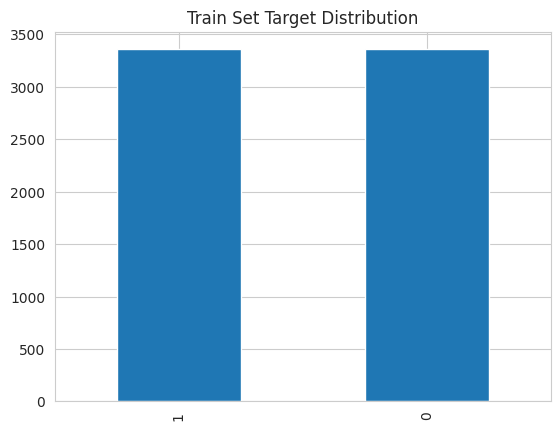

In [18]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm

In [19]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier

In [20]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results - it appears all classifiers score 100%, will select `LogisticRegression` as the simplest model.

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,1.0,1.0,1.0,0.0
1,XGBClassifier,1.0,1.0,1.0,0.0
2,DecisionTreeClassifier,1.0,1.0,1.0,0.0
3,RandomForestClassifier,1.0,1.0,1.0,0.0
4,GradientBoostingClassifier,1.0,1.0,1.0,0.0
5,ExtraTreesClassifier,1.0,1.0,1.0,0.0
6,AdaBoostClassifier,1.0,1.0,1.0,0.0


In [33]:
models_search = {
    "LogisticRegression":LogisticRegression(random_state=0),
}

params_search = {
    "LogisticRegression":{
        'model__solver': ['saga', 'liblinear'],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10]
    }
}

Extensive GridSearch CV - Binary Classifier 

In [87]:
from sklearn.metrics import recall_score, make_scorer, f1_score, accuracy_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(f1_score, pos_label=0),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.

Check results

In [88]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__C,model__penalty,model__solver
13,LogisticRegression,0.987952,0.988852,0.989458,0.000564,10,l1,liblinear
8,LogisticRegression,0.986405,0.988394,0.989458,0.001141,1,l1,saga
9,LogisticRegression,0.986405,0.988394,0.989458,0.001141,1,l1,liblinear
12,LogisticRegression,0.986405,0.988394,0.989458,0.001141,10,l1,saga
14,LogisticRegression,0.986405,0.988394,0.989458,0.001141,10,l2,saga
15,LogisticRegression,0.986405,0.988394,0.989458,0.001141,10,l2,liblinear
2,LogisticRegression,0.98717,0.988241,0.990218,0.001326,0.01,l2,saga
10,LogisticRegression,0.986405,0.987784,0.989458,0.001217,1,l2,saga
11,LogisticRegression,0.986405,0.987784,0.989458,0.001217,1,l2,liblinear
3,LogisticRegression,0.986405,0.987478,0.989458,0.001034,0.01,l2,liblinear


Get best model name

In [89]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LogisticRegression'

Parameters for best model

In [90]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}

Define the best clf pipeline

In [91]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(random_state=0))),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=0,
                                    solver='liblinear'))])

## Assess feature importance

In [92]:
X_train.head(3)

,cap-shape,cap-surface,cap-color,odor,gill-spacing,gill-size,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,population,habitat
0,0.279035,0.438147,0.558981,0.964374,0.913289,0.699396,0.454675,0.285066,0.700097,0.613947,0.616084,0.516387,0.506375,0.87885,0.790661,0.698318,0.655093
1,0.529735,0.674506,0.686203,0.964374,0.913289,0.699396,0.454675,0.285066,0.700097,0.613947,0.616084,0.516387,0.506375,0.87885,0.790661,1.000000,0.655093
2,0.529735,0.438147,0.686203,1.000000,0.438948,0.699396,0.454675,0.912037,0.700097,0.613947,0.616084,0.516387,0.506375,0.48955,0.790661,0.698318,0.865217


Using current model, can assess feature importance from model coefficients

* These are the 6 most important features in descending order. The model was trained on them: 
['odor', 'veil-color', 'population', 'stalk-surface-above-ring', 'cap-surface', 'gill-size']


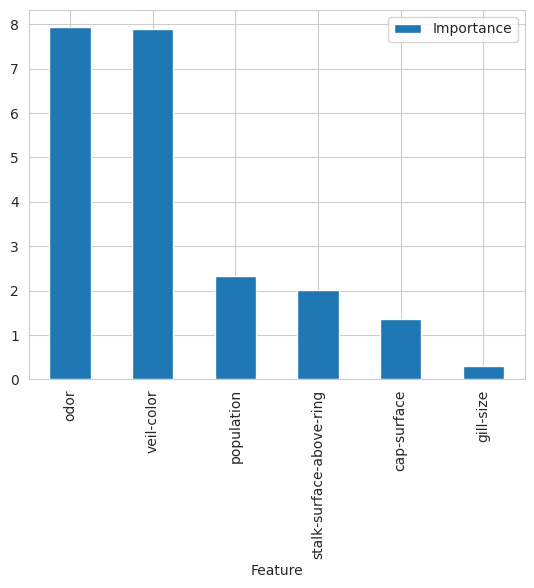

In [93]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].coef_[0]})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [85]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation: We cross check with metrics defined at ML business case

* 

In [94]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=['poisonous', 'edible']
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual poisonous Actual edible
Prediction poisonous             3287             0
Prediction edible                  69          3356


---  Classification Report  ---
              precision    recall  f1-score   support

   poisonous       1.00      0.98      0.99      3356
      edible       0.98      1.00      0.99      3356

    accuracy                           0.99      6712
   macro avg       0.99      0.99      0.99      6712
weighted avg       0.99      0.99      0.99      6712
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual poisonous Actual edible
Prediction poisonous              760             0
Prediction edible                  13           852


---  Classification Report  ---
              precision    recall  f1-score   support

   poisonous       1.00      0.98      0.99       773
      edible       0.98      1.00      0.99       852

    accuracy                   

In [102]:
pred_proba_df = pd.DataFrame(pipeline_clf.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1),
                                           Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))


******** For i = 0.05 ******

******** For i = 0.1 ******

******** For i = 0.15 ******

******** For i = 0.2 ******

******** For i = 0.25 ******

******** For i = 0.3 ******

******** For i = 0.35 ******

******** For i = 0.4 ******

******** For i = 0.45 ******

******** For i = 0.5 ******

******** For i = 0.55 ******

******** For i = 0.6 ******

******** For i = 0.65 ******

******** For i = 0.7 ******

******** For i = 0.75 ******

******** For i = 0.8 ******

******** For i = 0.85 ******

******** For i = 0.9 ******

******** For i = 0.95 ******

******** For i = 0.99 ******


,0,1
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1620,0,0
1621,0,1
1622,1,0
1623,0,1


---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
